<a href="https://colab.research.google.com/github/zubejda/Advanced_DL/blob/main/minimal_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alternatvie text](https://www.doc.zuv.fau.de//M/FAU-Logo/01_FAU_Kernmarke/Web/FAU_Kernmarke_Q_RGB_blue.svg)



# Assignment 3: Minimal GAN in PyTorch

Generative adversarial network (GAN) are well-known deep generative models proposed by [Ian Goodfellow](https://www.iangoodfellow.com) that could be used for synthesising data. It consists of two components, a generator (G) network that learns the data distribution and generates new examples and a discriminator (D) network that distinguishes between real and fake examples i.e. examples generated by G. In this assignment, you'll be asked to implement a series of tasks related to GANs using MNIST and Fashion-MNIST datasets. You upload your use a local python editor or python notebook e.g. Jupyter to implement your solution.

Prior to the assignment, it is necessary to install a package manager e.g. [conda](https://docs.conda.io/en/latest/), and [PyTorch](https://pytorch.org) framework.

## 1. Implement GAN in PyTorch


This public github [repository](https://github.com/bazilas/minimal-gan) implements GANs using tensorflow framework to reconstruct samples from MNIST and Fashion-MNIST data The first task is to re-implement the code (gan.py) using PyTorch framework instead. You should report your training performance i.e. train loss as a figure and another figure containing a batch of generated images after training.

In [ ]:
!pip install comet_ml > /dev/null 2>&1

In [ ]:
import comet_ml
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from getpass import getpass

In [ ]:
api_key = getpass('Enter your Comet API key: ')

os.environ['COMET_API_KEY'] = api_key

# Retrieve the API key from the environment variable
COMET_API_KEY = os.getenv('COMET_API_KEY')

In [ ]:
#setup generator
zdim = 50
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(zdim, 128),
            nn.ReLU(),
            # nn.Linear(64, 128),
            # nn.ReLU(),
            # nn.Linear(128, 256),
            # nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [ ]:
#setup discriminator
xdim = 784
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(xdim, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            # # nn.Linear(256, 128),
            # nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 1),
        )
        self.prob = nn.Sigmoid()
    def forward(self, input):
        x = self.main(input)
        return x, self.prob(x)

In [ ]:
# Count the number of trainable parameters
gen = Generator()
disc = Discriminator()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(gen)
print(f"Total trainable (generator) parameters: {total_params}")
total_params = count_parameters(disc)
print(f"Total trainable (discriminator) parameters: {total_params}")

In [ ]:
# create a sample
def draw_sample(m, n):
    return np.random.uniform(-1.0, 1.0, size=[m, n]).astype(np.float32)

In [ ]:
def get_n_samples(data_loader, n):
    samples = []
    data_iter = iter(data_loader)

    while len(samples) < n:
        try:
            imgs, _ = next(data_iter)
            samples.append(imgs)
        except StopIteration:
            data_iter = iter(data_loader)

    samples = torch.cat(samples)[:n]
    return samples

In [ ]:
##load  MNIST

params = dict(
  num_epochs = 200,
  batch_size = 64,
  learning_rate = 0.0002,
  momentum=1e-4,
  fashion_mnist = False
)

if params['fashion_mnist'] == False:
    dataset = datasets.MNIST('MNIST_data', train=True, download=True, transform=transforms.ToTensor())
else:
    dataset = datasets.FashionMNIST('Fashion-MNIST_data', train=True, download=True, transform=transforms.ToTensor())

data_loader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
### Create a Comet experiment to track our training run ###

def create_experiment():
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="ADL_GAN1",)
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

In [ ]:
#training loop
x = torch.tensor(draw_sample(1, 784), dtype=torch.float32).to(device)
z = torch.tensor(draw_sample(1, zdim), dtype=torch.float32).to(device)

G = Generator().to(device)
D = Discriminator().to(device)

G_sample_train = G(z)
D_logit_real, D_real = D(x)
D_logit_gen, D_fake = D(G_sample_train.detach())
G_sample_inf = G(z)

criterion = nn.BCEWithLogitsLoss()

D_loss_real = criterion(D_logit_real, torch.ones_like(D_logit_real))
D_loss_gen = criterion(D_logit_gen, torch.zeros_like(D_logit_gen))
D_loss = D_loss_real + D_loss_gen

G_loss = criterion(D_logit_gen, torch.ones_like(D_logit_gen))

opt_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.8, 0.999))
opt_d = optim.Adam(D.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [ ]:
# test_samples = get_n_samples(data_loader, 9)
experiment = create_experiment()

for epoch in range(params['num_epochs']):
    for batch_idx, (real_imgs, _) in enumerate(data_loader):
        # Update discriminator
        real_imgs = real_imgs.view(-1, 784).to(device)
        z = torch.tensor(draw_sample(params['batch_size'], zdim)).to(device)

        opt_d.zero_grad()

        G_sample_train = G(z)
        D_logit_real, D_real = D(real_imgs)
        D_logit_gen, D_fake = D(G_sample_train.detach())

        D_loss_real = criterion(D_logit_real, torch.ones_like(D_logit_real))
        D_loss_gen = criterion(D_logit_gen, torch.zeros_like(D_logit_gen))
        D_loss = D_loss_real + D_loss_gen

        D_loss.backward()
        nn.utils.clip_grad_norm_(D.parameters(), max_norm=1.0)  # Gradient clipping
        opt_d.step()

        # Update generator
        # z = torch.tensor(draw_sample(params['batch_size'], zdim)).to(device)
        opt_g.zero_grad()

        # G_sample_train = G(z)
        D_logit_gen, D_fake = D(G_sample_train)

        G_loss = criterion(D_logit_gen, torch.ones_like(D_logit_gen))

        G_loss.backward()
        nn.utils.clip_grad_norm_(G.parameters(), max_norm=1.0)  # Gradient clipping
        opt_g.step()

    # if epoch % 20 == 0:
    print(f'Epoch [{epoch}/{params["num_epochs"]}], D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}, D_loss_real: {D_loss_real.item():.4f}, D_loss_gen: {D_loss_gen.item():.4f}, Total loss: {G_loss.item() + D_loss.item():.4f}, ratio: {G_loss.item() / D_loss.item():.4f}')

    if epoch % 20 == 0 or G_loss.item() < 1.75:
        noise = torch.tensor(draw_sample(100, zdim)).to(device)
        samples = G(noise)
        fig = plt.figure(figsize=(10, 10))
        gs = gridspec.GridSpec(10, 10)
        for j, sample in enumerate(samples):
            sample = sample.detach().cpu().numpy()
            ax = plt.subplot(gs[j])
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        path = '/content/res'
        if not os.path.exists(path):
            os.makedirs(path)
        plt.savefig('/content/res/{}.png'.format(str(epoch).zfill(4)), bbox_inches='tight')
        plt.close()
        if epoch % 20 != 0:
            models_path = '/content/models/'
            if not os.path.exists(models_path):
                os.makedirs(models_path)
            torch.save(G.state_dict(), models_path + 'generator'+str(epoch)+'.pth')
            torch.save(D.state_dict(), models_path + 'discriminator'+str(epoch)+'.pth')

    experiment.log_metric("generator_loss", G_loss, step=epoch)
    experiment.log_metric("discriminator_loss", D_loss, step=epoch)

experiment.flush()

In [ ]:
#plot losses and generated images
noise = torch.tensor(draw_sample(9, zdim), dtype=torch.float32).to(device)
samples = G(noise)
# samples = get_n_samples(data_loader, 9)
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
for j, sample in enumerate(samples):
    sample = sample.detach().cpu().numpy()
    ax = plt.subplot(gs[j])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

plt.savefig('/content/res/{}.png'.format(str(j).zfill(7)), bbox_inches='tight')
plt.close()

## 2a. Implement GAN with Convolutional architecture.

Convolurional neural networks (CNNs) have a better feature representation, unlike, fully connected layers. Hence, it is required here to modify your code to include CNNs in your script. For more information, check out this [tutorial](https://gucifer.github.io/mediator/feature/2021/08/11/GAN-evaluation-using-FID-and-IS.html).

Similar to before, please report your training performance i.e. train loss as a figure and another figure containing a batch of generated images after training. You can plot one figure including and highlight the train loss using fully connected and CNN networks.

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from getpass import getpass
from google.colab import files

In [ ]:
#load MNIST

params = dict(
    img_shape = [32, 32],
    latent_dim = 50,
    num_epochs = 20,
    batch_size = 64,
    learning_rate = 0.0002,
    momentum=1e-4,
    fashion_mnist = False
)

data_transform = transforms.Compose(
    [
        transforms.Resize(params['img_shape']),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]
)

if params['fashion_mnist'] == False:
    dataset = datasets.MNIST('MNIST_data', train=True, download=True, transform=data_transform)
else:
    dataset = datasets.FashionMNIST('Fashion-MNIST_data', train=True, download=True, transform=data_transform)

data_loader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
#setup convolutional generator
class CNN_Generator(nn.Module):
    def __init__(self, latent_dim, feature_maps=16, img_channels=1):
        super(CNN_Generator, self).__init__()
        self.latent_dim = latent_dim
        self.feature_maps = feature_maps
        self.img_channels = img_channels

        self.model = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(self.latent_dim, self.feature_maps * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(self.feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.feature_maps * 4, self.feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.feature_maps * 2, self.feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.feature_maps, self.img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Output: img_channels x 32 x 32
    )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
gen = CNN_Generator(params['latent_dim']).to(device)
example_img = data_loader.dataset[0][0] # single image from a dataset
noise = torch.randn(100, params['latent_dim'], 1, 1, device=device) # generating a single latent vecotr for testing
generated_noise = gen(noise)
for i in generated_noise:
    print(i.reshape(params['img_shape']).shape)
    break
# print(generated_noise.reshape(params['img_shape']).shape)

torch.Size([32, 32])


In [ ]:
#setup convolutional discriminator
class CNN_Discriminator(nn.Module):
    def __init__(self, latent_dim, feature_maps=16, img_channels=1):
        super(CNN_Discriminator, self).__init__()
        self.latent_dim = latent_dim
        self.feature_maps = feature_maps
        self.img_channels = img_channels

        self.model = nn.Sequential(
            nn.Conv2d(self.img_channels, self.feature_maps, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.feature_maps, self.feature_maps * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.feature_maps * 2, self.feature_maps * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.feature_maps * 4, self.latent_dim, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(latent_dim),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.latent_dim, 1, 1, stride=1, padding=0, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # print("parameters shape", self.latent_dim, self.feature_maps, self.img_channels)
        # print("input shape", x.shape)
        logits = self.model(x)
        res = self.sigmoid(logits)
        return logits, res

In [ ]:
disc = CNN_Discriminator(params['latent_dim']).to(device)
duplicated_tensor = generated_noise.repeat(2, 1, 1, 1) # duplicate the tensor to make it (2, 100, 1, 1) so it can run through the discriminator
log, result = disc(duplicated_tensor)
print(log.shape)

torch.Size([200, 1, 1, 1])


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(gen)
print(f"Total trainable (generator) parameters: {total_params}")
total_params = count_parameters(disc)
print(f"Total trainable (discriminator) parameters: {total_params}")

Total trainable (generator) parameters: 92640
Total trainable (discriminator) parameters: 92758


In [ ]:
# create a sample
def draw_sample(sample_shape):
    return np.random.uniform(-1.0, 1.0, size=sample_shape).astype(np.float32)

In [ ]:
#training loop
# x = torch.tensor(draw_sample(1, 784), dtype=torch.float32).to(device)
# z = torch.tensor(draw_sample(1, zdim), dtype=torch.float32).to(device)

G = CNN_Generator(params['latent_dim']).to(device)
D = CNN_Discriminator(params['latent_dim']).to(device)

# G_sample_train = G(z)
# D_logit_real, D_real = D(x)
# D_logit_gen, D_fake = D(G_sample_train.detach())
# G_sample_inf = G(z)

criterion = nn.BCEWithLogitsLoss()

# D_loss_real = criterion(D_logit_real, torch.ones_like(D_logit_real))
# D_loss_gen = criterion(D_logit_gen, torch.zeros_like(D_logit_gen))
# D_loss = D_loss_real + D_loss_gen

# G_loss = criterion(D_logit_gen, torch.ones_like(D_logit_gen))

opt_g = optim.Adam(G.parameters(), lr=0.0001, betas=(0.75, 0.999))
opt_d = optim.Adam(D.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [ ]:
#training loop

for epoch in range(params['num_epochs']):
    for batch_idx, (real_imgs, _) in enumerate(data_loader):
        # Update discriminator
        real_imgs = real_imgs.to(device)
        z = torch.tensor(draw_sample((params['batch_size'], params['latent_dim'], 1, 1))).to(device)

        opt_d.zero_grad()

        G_sample_train = G(z)
        # print(real_imgs.shape)
        D_logit_real, D_real = D(real_imgs)
        D_logit_gen, D_fake = D(G_sample_train.detach())

        D_loss_real = criterion(D_logit_real, torch.ones_like(D_logit_real))
        D_loss_gen = criterion(D_logit_gen, torch.zeros_like(D_logit_gen))
        D_loss = D_loss_real + D_loss_gen

        D_loss.backward()
        nn.utils.clip_grad_norm_(D.parameters(), max_norm=1.0)  # Gradient clipping
        opt_d.step()

        # Update generator
        # z = torch.tensor(draw_sample(params['batch_size'], zdim)).to(device)
        opt_g.zero_grad()

        # G_sample_train = G(z)
        D_logit_gen, D_fake = D(G_sample_train)

        G_loss = criterion(D_logit_gen, torch.ones_like(D_logit_gen))

        G_loss.backward()
        nn.utils.clip_grad_norm_(G.parameters(), max_norm=1.0)  # Gradient clipping
        opt_g.step()

        # if batch_idx % 100 == 0:
        #     print(batch_idx)

    noise = torch.randn(100, params['latent_dim'], 1, 1, device=device)
    samples = G(noise)

    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    for j, sample in enumerate(samples):
        sample = sample.detach().cpu().numpy()
        ax = plt.subplot(gs[j])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(sample.reshape(params['img_shape']), cmap='Greys_r')

    path = '/content/res'
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig('/content/res/{}.png'.format(str(epoch).zfill(4)), bbox_inches='tight')
    plt.close()

    # if epoch % 20 == 0:
    print(f'Epoch [{epoch}/{params["num_epochs"]}], D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}, D_loss_real: {D_loss_real.item():.4f}, D_loss_gen: {D_loss_gen.item():.4f}, Total loss: {G_loss.item() + D_loss.item():.4f}, ratio: {G_loss.item() / D_loss.item():.4f}')

Epoch [0/20], D_loss: 1.1374, G_loss: 0.8721, D_loss_real: 0.5834, D_loss_gen: 0.5540, Total loss: 2.0095, ratio: 0.7668
Epoch [1/20], D_loss: 0.9077, G_loss: 1.0777, D_loss_real: 0.4644, D_loss_gen: 0.4433, Total loss: 1.9853, ratio: 1.1873
Epoch [2/20], D_loss: 0.8656, G_loss: 1.1308, D_loss_real: 0.4365, D_loss_gen: 0.4291, Total loss: 1.9963, ratio: 1.3064
Epoch [3/20], D_loss: 1.0359, G_loss: 1.0769, D_loss_real: 0.5704, D_loss_gen: 0.4656, Total loss: 2.1128, ratio: 1.0395
Epoch [4/20], D_loss: 0.8490, G_loss: 1.2497, D_loss_real: 0.4582, D_loss_gen: 0.3908, Total loss: 2.0987, ratio: 1.4720
Epoch [5/20], D_loss: 0.8092, G_loss: 1.1909, D_loss_real: 0.3633, D_loss_gen: 0.4459, Total loss: 2.0001, ratio: 1.4716
Epoch [6/20], D_loss: 0.7318, G_loss: 1.4285, D_loss_real: 0.3704, D_loss_gen: 0.3614, Total loss: 2.1603, ratio: 1.9520
Epoch [7/20], D_loss: 0.7484, G_loss: 1.3951, D_loss_real: 0.3832, D_loss_gen: 0.3651, Total loss: 2.1434, ratio: 1.8642
Epoch [8/20], D_loss: 1.2068, G_

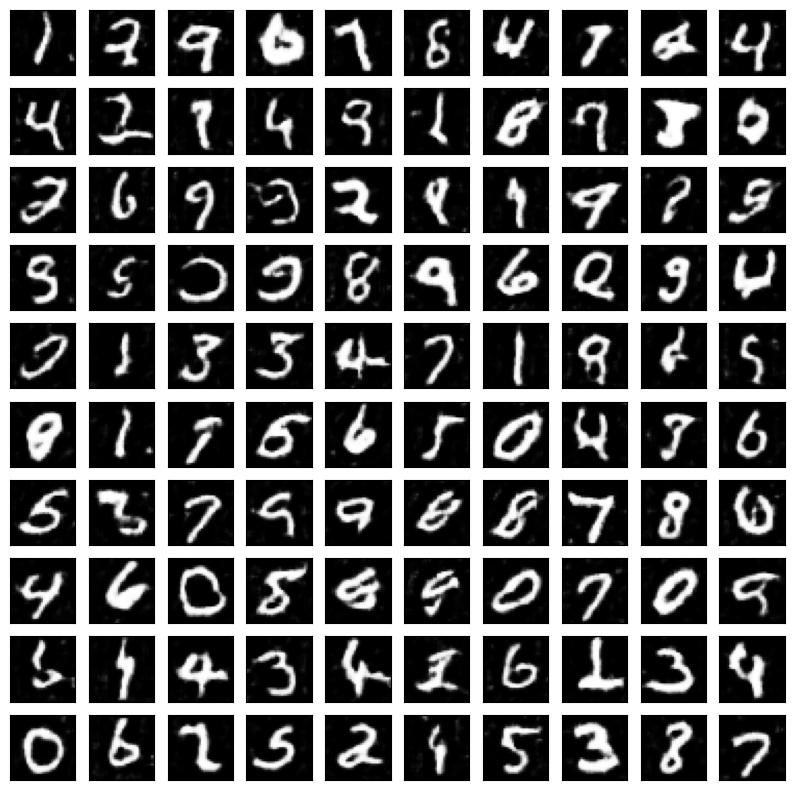

In [ ]:
models_path = '/content/final'
if not os.path.exists(models_path):
    os.makedirs(models_path)

G_losses = {"generator_loss": G_loss.item()}
D_losses = {"discriminator_loss_real": D_loss_real.item(),
            "discriminator_loss_gen": D_loss_gen.item(),
            "discriminator_loss_total": D_loss.item()}

torch.save({
    'model_state_dict': G.state_dict(),
    'optimizer_state_dict': opt_g.state_dict(),
    'losses': G_losses,
    'metadata': params
}, os.path.join(models_path, 'G.pth'))
torch.save({
    'model_state_dict': D.state_dict(),
    'optimizer_state_dict': opt_d.state_dict(),
    'losses': D_losses,
    'metadata': params
}, os.path.join(models_path, 'D.pth'))

noise = torch.randn(100, params['latent_dim'], 1, 1, device=device)
samples = G(noise)

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
for j, sample in enumerate(samples):
    sample = sample.detach().cpu().numpy()
    ax = plt.subplot(gs[j])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sample.reshape(params['img_shape']), cmap='Greys_r')

plt.savefig(models_path + '/{}.png'.format(str(epoch).zfill(4)), bbox_inches='tight')

folder_to_zip = 'final'
os.system(f'zip -r {folder_to_zip}.zip {folder_to_zip}')
files.download(f'{folder_to_zip}.zip') # zip and download the folder with the final weights and generetade picture

In [ ]:
#plot losses and generated images with the convolutional GAN

## 2b. now reimplement this with FASHION-MNIST with a convolutinal architecture

In [ ]:
#load MNIST

params = dict(
    img_shape = [32, 32],
    latent_dim = 50,
    num_epochs = 20,
    batch_size = 64,
    learning_rate = 0.0002,
    momentum=1e-4,
    fashion_mnist = True
)

data_transform = transforms.Compose(
    [
        transforms.Resize(params['img_shape']),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]
)

if params['fashion_mnist'] == False:
    dataset = datasets.MNIST('MNIST_data', train=True, download=True, transform=data_transform)
else:
    dataset = datasets.FashionMNIST('Fashion-MNIST_data', train=True, download=True, transform=data_transform)

data_loader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

100%|██████████| 26421880/26421880 [00:03<00:00, 8499664.53it/s] 


Extracting Fashion-MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to Fashion-MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 140183.93it/s]


Extracting Fashion-MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Fashion-MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 497402.15it/s] 


Extracting Fashion-MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Fashion-MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14481741.78it/s]


Extracting Fashion-MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Fashion-MNIST_data/FashionMNIST/raw

cpu


In [ ]:
#training loop
# x = torch.tensor(draw_sample(1, 784), dtype=torch.float32).to(device)
# z = torch.tensor(draw_sample(1, zdim), dtype=torch.float32).to(device)

G = CNN_Generator(params['latent_dim']).to(device)
D = CNN_Discriminator(params['latent_dim']).to(device)

# G_sample_train = G(z)
# D_logit_real, D_real = D(x)
# D_logit_gen, D_fake = D(G_sample_train.detach())
# G_sample_inf = G(z)

criterion = nn.BCEWithLogitsLoss()

# D_loss_real = criterion(D_logit_real, torch.ones_like(D_logit_real))
# D_loss_gen = criterion(D_logit_gen, torch.zeros_like(D_logit_gen))
# D_loss = D_loss_real + D_loss_gen

# G_loss = criterion(D_logit_gen, torch.ones_like(D_logit_gen))

opt_g = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
opt_d = optim.Adam(D.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [ ]:
#training loop

for epoch in range(params['num_epochs']):
    for batch_idx, (real_imgs, _) in enumerate(data_loader):
        # Update discriminator
        real_imgs = real_imgs.to(device)
        z = torch.tensor(draw_sample((params['batch_size'], params['latent_dim'], 1, 1))).to(device)

        opt_d.zero_grad()

        G_sample_train = G(z)
        # print(real_imgs.shape)
        D_logit_real, D_real = D(real_imgs)
        D_logit_gen, D_fake = D(G_sample_train.detach())

        D_loss_real = criterion(D_logit_real, torch.ones_like(D_logit_real))
        D_loss_gen = criterion(D_logit_gen, torch.zeros_like(D_logit_gen))
        D_loss = D_loss_real + D_loss_gen

        D_loss.backward()
        nn.utils.clip_grad_norm_(D.parameters(), max_norm=1.0)  # Gradient clipping
        opt_d.step()

        # Update generator
        # z = torch.tensor(draw_sample(params['batch_size'], zdim)).to(device)
        opt_g.zero_grad()

        # G_sample_train = G(z)
        D_logit_gen, D_fake = D(G_sample_train)

        G_loss = criterion(D_logit_gen, torch.ones_like(D_logit_gen))

        G_loss.backward()
        nn.utils.clip_grad_norm_(G.parameters(), max_norm=1.0)  # Gradient clipping
        opt_g.step()

        # if batch_idx % 100 == 0:
        #     print(batch_idx)

    noise = torch.randn(100, params['latent_dim'], 1, 1, device=device)
    samples = G(noise)

    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    for j, sample in enumerate(samples):
        sample = sample.detach().cpu().numpy()
        ax = plt.subplot(gs[j])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(sample.reshape(params['img_shape']), cmap='Greys_r')

    path = '/content/res'
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig('/content/res/{}.png'.format(str(epoch).zfill(4)), bbox_inches='tight')
    plt.close()

    # if epoch % 20 == 0:
    print(f'Epoch [{epoch}/{params["num_epochs"]}], D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}, D_loss_real: {D_loss_real.item():.4f}, D_loss_gen: {D_loss_gen.item():.4f}, Total loss: {G_loss.item() + D_loss.item():.4f}, ratio: {G_loss.item() / D_loss.item():.4f}')

## 3. Conditional GAN (cGAN)

Vanilla GANs produce synthetic images by drawing a random vector from latent space. However, we may condition the GAN to additional information, namely, a class label e.g. label  "0" in MNIST. This requires to additionally input the label to G and D networks along with random vector drawn from latent space. You may use this [cGAN](https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/) tutorial to implement a cGAN based on the convolutional archiecture you've implemented before. Furthermore, MNIST should be used in this task.

In [1]:
#necessary imports
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from getpass import getpass
from google.colab import files

In [87]:
#dataset and hyperparameters

params = dict(
    img_shape = [32, 32],
    latent_dim = 50,
    num_epochs = 50,
    batch_size = 64,
    learning_rate = 0.0002,
    momentum=1e-4,
    fashion_mnist = False
)

data_transform = transforms.Compose(
    [
        transforms.Resize(params['img_shape']),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]
)

if params['fashion_mnist'] == False:
    dataset = datasets.MNIST('MNIST_data', train=True, download=True, transform=data_transform)
else:
    dataset = datasets.FashionMNIST('Fashion-MNIST_data', train=True, download=True, transform=data_transform)

data_loader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True)
params['num_classes'] = len(data_loader.dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [88]:
# create a sample
def draw_sample(sample_shape):
    return np.random.uniform(-1.0, 1.0, size=sample_shape).astype(np.float32)

In [89]:
#generator and discriminator
class Conditional_Generator(nn.Module):
    def __init__(self, latent_dim, feature_maps=16, img_channels=1, num_classes=10, encoded_shape=4):
        super(Conditional_Generator, self).__init__()
        self.latent_dim = latent_dim
        self.feature_maps = feature_maps
        self.img_channels = img_channels
        self.num_classes = num_classes
        self.encoded_shape = encoded_shape # shape into which the noise encoding is reshaped
        self.conv_input_dim = self.feature_maps * 8

        self.label_encoding = nn.Sequential(
                            nn.Embedding(self.num_classes, self.latent_dim),
                            nn.Linear(self.latent_dim, self.feature_maps))

        self.noise_encoding = nn.Sequential(
            nn.Linear(self.latent_dim, self.conv_input_dim * self.encoded_shape * self.encoded_shape),
            nn.LeakyReLU(0.2),
        )

        self.model = nn.Sequential(
            nn.ConvTranspose2d(self.conv_input_dim+1, self.feature_maps * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(self.feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.feature_maps * 4, self.feature_maps * 2, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.feature_maps * 2, self.feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(self.feature_maps, self.img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
    )

    def forward(self, x, y, b=False):
        batch_size = x.shape[0]

        label_enc = self.label_encoding(y).reshape(batch_size, -1, self.encoded_shape, self.encoded_shape)
        noise_embedding = self.noise_encoding(x).reshape(batch_size, -1, self.encoded_shape, self.encoded_shape)
        # print(label_enc.shape)
        # print(x.shape)
        # print(self.conv_input_dim)
        # print(noise_embedding.shape)

        conv_input = torch.cat([label_enc, noise_embedding], dim=1)
        # print(conv_input.shape)

        out = self.model(conv_input)
        # print(out.shape)

        return out


class Conditional_Discriminator(nn.Module):
    def __init__(self, latent_dim, feature_maps=16, img_channels=1, num_classes=10, img_size=32*32):
        super(Conditional_Discriminator, self).__init__()
        self.latent_dim = latent_dim
        self.feature_maps = feature_maps
        self.img_channels = img_channels
        self.num_classes = num_classes
        self.img_size = img_size

        self.label_encoding = nn.Sequential(
                            nn.Embedding(self.num_classes, self.latent_dim),
                            nn.Linear(self.latent_dim, self.img_size*self.img_channels))

        self.model = nn.Sequential(
            nn.Conv2d(self.img_channels+1, self.feature_maps, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.feature_maps, self.feature_maps * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.feature_maps * 2, self.feature_maps * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.feature_maps * 4, self.latent_dim, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(latent_dim),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.latent_dim, 1, 1, stride=1, padding=0, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        batch_size = x.shape[0]
        label_enc = self.label_encoding(y).reshape(batch_size, self.img_channels, 32, 32)

        conv_input = torch.cat([x, label_enc], dim=1)
        # print(label_enc.shape)
        # print(x.shape)
        # print(conv_input.shape)

        logits = self.model(conv_input)
        res = self.sigmoid(logits)
        # print(logits.shape)
        # print(res.shape)
        return logits, res

In [90]:
test_noise = torch.tensor(draw_sample((params['batch_size'], params['latent_dim']))).to(device)
gen = Conditional_Generator(params['latent_dim'], feature_maps=16, img_channels=1).to(device)
test_class = torch.randint(0, 10, (params['batch_size'], 1)).to(device)
example_img = gen(test_noise, test_class)

disc = Conditional_Discriminator(params['latent_dim'], feature_maps=16, img_channels=1).to(device)
logits, res = disc(example_img, test_class)


In [91]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

gen = Conditional_Generator(params['latent_dim'], feature_maps=16, img_channels=1).to(device)
disc = Conditional_Discriminator(params['latent_dim'], feature_maps=16, img_channels=1).to(device)

total_params = count_parameters(gen)
print(f"Total trainable (generator) parameters: {total_params}")
total_params = count_parameters(disc)
print(f"Total trainable (discriminator) parameters: {total_params}")

Total trainable (generator) parameters: 279300
Total trainable (discriminator) parameters: 145738


In [92]:
#define training step for generator and discriminator

G = Conditional_Generator(params['latent_dim']).to(device)
D = Conditional_Discriminator(params['latent_dim']).to(device)

criterion = nn.BCEWithLogitsLoss()

opt_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_d = optim.Adam(D.parameters(), lr=0.00007, betas=(0.5, 0.999))

In [93]:
#training loop

for epoch in range(params['num_epochs']):
    for batch_idx, (real_imgs, class_labels) in enumerate(data_loader):
        # Update discriminator
        batch_size = class_labels.shape[0]

        valid_output = torch.ones((batch_size, 1), requires_grad=False).to(device)
        fake_output = torch.zeros((batch_size, 1), requires_grad=False).to(device)

        real_imgs = real_imgs.to(device)
        class_labels = class_labels.to(device)
        z = torch.tensor(draw_sample((batch_size, params['latent_dim']))).to(device)

        # Update generator
        opt_g.zero_grad()

        random_labels = torch.randint(0, params['num_classes'], (batch_size,)).to(device)

        G_sample_train = G(z, random_labels)
        D_logit_gen, D_fake = D(G_sample_train, random_labels)

        G_loss = criterion(D_logit_gen.reshape(-1, 1), valid_output)

        G_loss.backward()
        # nn.utils.clip_grad_norm_(G.parameters(), max_norm=1.0)  # Gradient clipping
        opt_g.step()

        # Update discriminator
        opt_d.zero_grad()

        D_logit_real, D_real = D(real_imgs, class_labels)
        D_logit_gen, D_fake = D(G_sample_train.detach(), random_labels)

        # print(valid_output.shape)
        D_loss_real = criterion(D_logit_real.reshape(-1 ,1), valid_output)
        D_loss_gen = criterion(D_logit_gen.reshape(-1, 1), fake_output)
        D_loss = D_loss_real + D_loss_gen

        D_loss.backward()
        # nn.utils.clip_grad_norm_(D.parameters(), max_norm=1.0)  # Gradient clipping
        opt_d.step()

        # if batch_idx % 100 == 0:
        #     print(batch_idx)

    # print(f'Epoch [{epoch}/{params["num_epochs"]}], D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}, D_loss_real: {D_loss_real.item():.4f}, D_loss_gen: {D_loss_gen.item():.4f}, Total loss: {G_loss.item() + D_loss.item():.4f}, ratio: {G_loss.item() / D_loss.item():.4f}')

    if epoch % 2 == 0:
        noise = torch.randn(100, params['latent_dim'], device=device)
        random_labels = torch.randint(0, 10, (100, 1), device=device)
        samples = G(noise, random_labels)

        fig = plt.figure(figsize=(10, 10))
        gs = gridspec.GridSpec(10, 10)
        for j, sample in enumerate(samples):
            sample = sample.detach().cpu().numpy()
            ax = plt.subplot(gs[j])
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(sample.reshape(params['img_shape']), cmap='Greys_r')

        path = '/content/res'
        if not os.path.exists(path):
            os.makedirs(path)
        plt.savefig('/content/res/{}.png'.format(str(epoch).zfill(4)), bbox_inches='tight')
        plt.close()

    # if epoch % 20 == 0:
    print(f'Epoch [{epoch}/{params["num_epochs"]}], D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}, D_loss_real: {D_loss_real.item():.4f}, D_loss_gen: {D_loss_gen.item():.4f}, Total loss: {G_loss.item() + D_loss.item():.4f}, ratio: {G_loss.item() / D_loss.item():.4f}')


Epoch [0/50], D_loss: 1.3609, G_loss: 0.6985, D_loss_real: 0.6673, D_loss_gen: 0.6936, Total loss: 2.0594, ratio: 0.5133
Epoch [1/50], D_loss: 1.3655, G_loss: 0.7183, D_loss_real: 0.6938, D_loss_gen: 0.6717, Total loss: 2.0838, ratio: 0.5260
Epoch [2/50], D_loss: 1.3897, G_loss: 0.6991, D_loss_real: 0.7006, D_loss_gen: 0.6892, Total loss: 2.0888, ratio: 0.5031
Epoch [3/50], D_loss: 1.4091, G_loss: 0.7086, D_loss_real: 0.7161, D_loss_gen: 0.6929, Total loss: 2.1177, ratio: 0.5029
Epoch [4/50], D_loss: 1.3558, G_loss: 0.7455, D_loss_real: 0.7096, D_loss_gen: 0.6462, Total loss: 2.1013, ratio: 0.5499
Epoch [5/50], D_loss: 1.2951, G_loss: 0.6774, D_loss_real: 0.5832, D_loss_gen: 0.7119, Total loss: 1.9725, ratio: 0.5231
Epoch [6/50], D_loss: 1.4249, G_loss: 0.6676, D_loss_real: 0.7037, D_loss_gen: 0.7211, Total loss: 2.0925, ratio: 0.4685


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

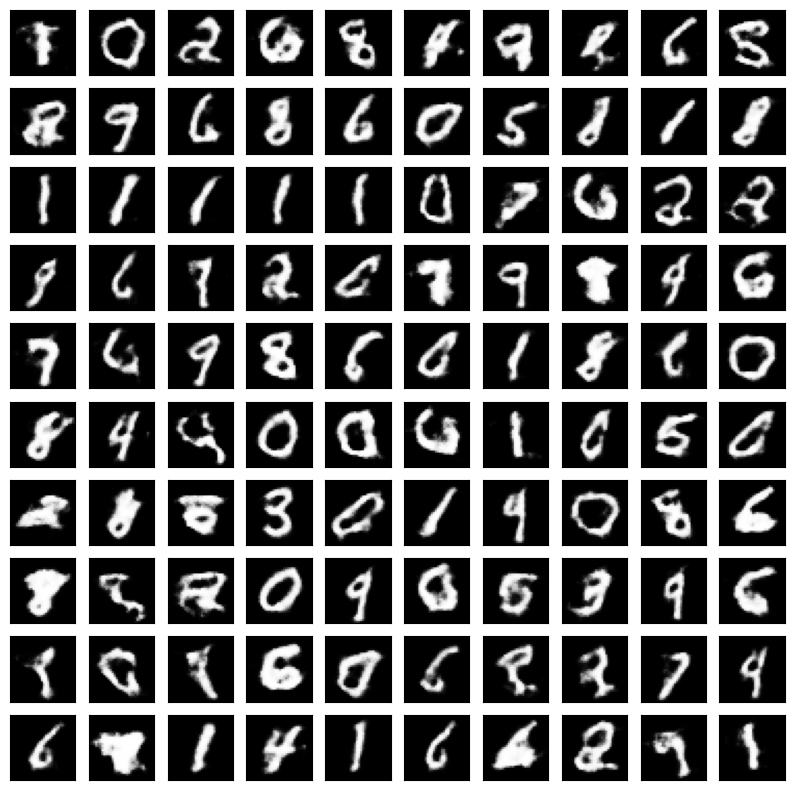

In [63]:
# saving of the model weigths and loss values, plus example images

models_path = '/content/final'
if not os.path.exists(models_path):
    os.makedirs(models_path)

G_losses = {"generator_loss": G_loss.item()}
D_losses = {"discriminator_loss_real": D_loss_real.item(),
            "discriminator_loss_gen": D_loss_gen.item(),
            "discriminator_loss_total": D_loss.item()}

torch.save({
    'model_state_dict': G.state_dict(),
    'optimizer_state_dict': opt_g.state_dict(),
    'losses': G_losses,
    'metadata': params
}, os.path.join(models_path, 'G.pth'))
torch.save({
    'model_state_dict': D.state_dict(),
    'optimizer_state_dict': opt_d.state_dict(),
    'losses': D_losses,
    'metadata': params
}, os.path.join(models_path, 'D.pth'))

noise = torch.randn(100, params['latent_dim'], device=device)
random_labels = torch.randint(0, 10, (100, 1), device=device)
samples = G(noise, random_labels)

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
for j, sample in enumerate(samples):
    sample = sample.detach().cpu().numpy()
    ax = plt.subplot(gs[j])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sample.reshape(params['img_shape']), cmap='Greys_r')

plt.savefig(models_path + '/{}.png'.format(str(epoch).zfill(4)), bbox_inches='tight')

folder_to_zip = 'final'
os.system(f'zip -r {folder_to_zip}.zip {folder_to_zip}')
files.download(f'{folder_to_zip}.zip') # zip and download the folder with the final weights and generetade picture

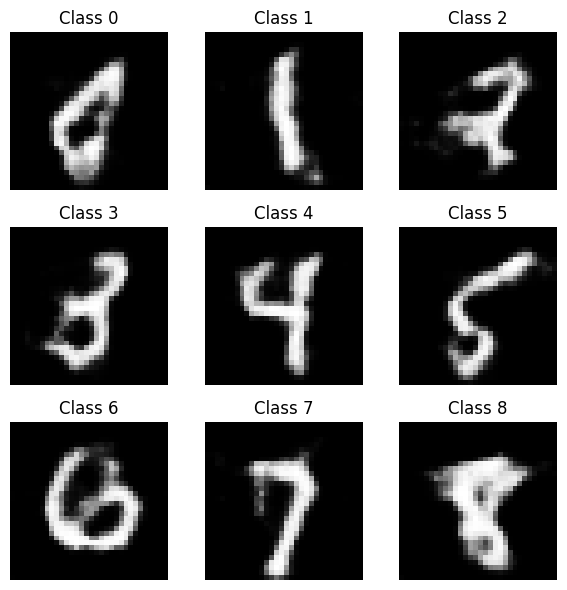

In [66]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i in range(9):
    # Generate a random noise vector and a specific label
    z = torch.randn(1, params['latent_dim'], device=device)  # Batch size of 1
    label = torch.tensor([i], device=device)  # Label from 0 to 8

    # Generate the image
    with torch.no_grad():
        gen_img = G(z, label)

    # Convert the generated image to a format that can be visualized
    gen_img = gen_img.squeeze().cpu().numpy()
    gen_img = (gen_img + 1) / 2  # Rescale to [0, 1]

    # Plot the generated image
    ax = axes[i // 3, i % 3]
    ax.imshow(gen_img, cmap='gray')
    ax.set_title(f"Class {label.item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()